##### Copyright 2022 The TensorFlow GNN Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Molecular Graph Classification with TF-GNN

<table class="tfo-notebook-buttons" align="left">
  <td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/intro_mutag_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/gnn/blob/main/examples/notebooks/intro_mutag_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
</table>

We will demonstrate how to do graph classification with TF-GNN.

For this example, we will do molecular property prediction, where each molecule is represented as a graph. Nodes correspond to atoms, and edges represent the bonds between them. This is one of the application areas where GNNs are now the method of choice.

We will use the MUTAG dataset, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

There are 188 graphs in this dataset, labeled with one of two classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features  represent the bond type.

Please note that this is an introductory example on homogeneous graphs (one node type, and one edge type). TF-GNN is designed to support heterogeneous graphs as well (multiple node types, and/or multiple edge types).

## Imports

Before Python can `import tensorflow_gnn`, the PIP package [`tensorflow-gnn`](https://pypi.org/project/tensorflow-gnn/) needs to be downloaded and installed.

TensorFlow 2.16+ must be [configured](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/keras_version.md) to use Keras v2 as `tf.keras`.

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # For TF2.16+.

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn

print(f'Running TF-GNN {tfgnn.__version__} with TensorFlow {tf.__version__}.')


Running TF-GNN 1.0.3 with TensorFlow 2.20.0.


### Download the MUTAG dataset
We have created a version of the MUTAG Dataset in TF-GNN's file format to use as an example in this colab.

Citation: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)

In [3]:
train_path = os.path.join(os.getcwd(), '..', 'data', 'mutag', 'train.tfrecords')
val_path = os.path.join(os.getcwd(), '..', 'data', 'mutag', 'val.tfrecords')

In [4]:
graph_tensor_spec = tfgnn.GraphTensorSpec.from_piece_specs(
    context_spec=tfgnn.ContextSpec.from_field_specs(features_spec={
                  'label': tf.TensorSpec(shape=(1,), dtype=tf.int32)
    }),
    node_sets_spec={
        'atoms':
            tfgnn.NodeSetSpec.from_field_specs(
                features_spec={
                    tfgnn.HIDDEN_STATE:
                        tf.TensorSpec((None, 7), tf.float32)
                },
                sizes_spec=tf.TensorSpec((1,), tf.int32))
    },
    edge_sets_spec={
        'bonds':
            tfgnn.EdgeSetSpec.from_field_specs(
                features_spec={
                    tfgnn.HIDDEN_STATE:
                        tf.TensorSpec((None, 4), tf.float32)
                },
                sizes_spec=tf.TensorSpec((1,), tf.int32),
                adjacency_spec=tfgnn.AdjacencySpec.from_incident_node_sets(
                    'atoms', 'atoms'))
    })


def decode_fn(record_bytes):
  graph = tfgnn.parse_single_example(
      graph_tensor_spec, record_bytes, validate=True)

  # extract label from context and remove from input graph
  context_features = graph.context.get_features_dict()
  label = context_features.pop('label')
  new_graph = graph.replace_features(context=context_features)

  return new_graph, label

In [5]:
train_ds = tf.data.TFRecordDataset([train_path]).map(decode_fn)
val_ds = tf.data.TFRecordDataset([val_path]).map(decode_fn)

### Look at one example from the dataset

In [6]:
n = 0  # Remplacez 2 par l'index de l'exemple que vous voulez choisir
g, y = train_ds.skip(n).take(1).get_single_element()

#### Node features

Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F,
4=I, 5=Cl, 6=Br).

In [7]:
print(g.node_sets['atoms'].features[tfgnn.HIDDEN_STATE])

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]], shape=(14, 7), dtype=float32)


#### Bond Edges

In this example, we consider the bonds between atoms undirected edges. To encode
them in the GraphsTuple, we store the undirected edges as pairs of directed
edges in both directions.

`adjacency.source` contains the source node indices, and `adjacency.target` contains the corresponding target node indices.

In [8]:
g.edge_sets['bonds'].adjacency.source

<tf.Tensor: shape=(28,), dtype=int32, numpy=
array([ 0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,
        6,  6,  7,  8,  9, 10, 11, 11, 11, 12, 13], dtype=int32)>

In [9]:
g.edge_sets['bonds'].adjacency.target

<tf.Tensor: shape=(28,), dtype=int32, numpy=
array([ 1,  5,  0,  2, 11,  1,  3,  2,  4, 10,  3,  5,  9,  0,  4,  6,  5,
        7,  8,  6,  6,  4,  3,  1, 12, 13, 11, 11], dtype=int32)>

#### Edge features

Edge features represent the bond type as one-hot encoding.

In [10]:
g.edge_sets['bonds'].features[tfgnn.HIDDEN_STATE]

<tf.Tensor: shape=(28, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

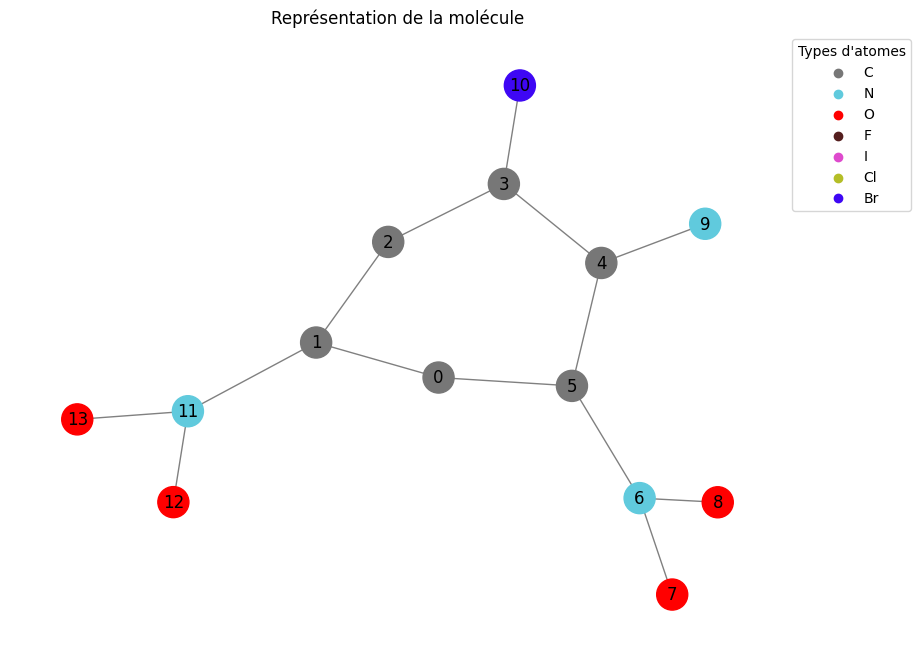

In [22]:
import networkx as nx

# Convertir le graphe TensorFlow GNN en un graphe NetworkX
def graph_tensor_to_networkx(graph_tensor):
    G = nx.Graph()

    # Ajouter les nœuds avec leurs types comme attributs
    node_features = graph_tensor.node_sets['atoms'].features[tfgnn.HIDDEN_STATE].numpy()
    num_nodes = graph_tensor.node_sets['atoms'].sizes[0].numpy()
    for i in range(num_nodes):
        atom_type = int(node_features[i].argmax())  # Type d'atome basé sur l'encodage one-hot
        G.add_node(i, atom_type=atom_type)

    # Ajouter les arêtes
    sources = graph_tensor.edge_sets['bonds'].adjacency.source.numpy()
    targets = graph_tensor.edge_sets['bonds'].adjacency.target.numpy()
    edges = zip(sources, targets)
    G.add_edges_from(edges)

    return G

# Convertir et afficher le graphe
nx_graph = graph_tensor_to_networkx(g)

# Définir les couleurs des nœuds en fonction du type d'atome
palette = dict(zip(range(7), ["#777777","#60CADD",'#FF0000',"#541E1E","#DE4ACD","#B4BE27","#3E07F4"]))
node_colors = [palette[d['atom_type']] for _, d in nx_graph.nodes(data=True)]

# Tracer le graphe avec les couleurs des nœuds
plt.figure(figsize=(10, 8))
plt.title("Représentation de la molécule")
nx.draw(nx_graph, with_labels=True, node_color=node_colors, cmap=plt.cm.tab10, edge_color='gray', node_size=500)

# Ajouter une légende pour les types d'atomes
atom_types = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br'] 
print(enumerate(atom_types))
for i, atom in enumerate(atom_types):
    plt.scatter([], [], color=palette[i], label=atom)
plt.legend(title="Types d'atomes", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Label
The label is binary, indicating the mutagenicity of the molecule. It's either 0 or 1.

In [12]:
y

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>

#### Batch the datasets

In [13]:
batch_size = 32
train_ds_batched = train_ds.batch(batch_size=batch_size).repeat()
val_ds_batched = val_ds.batch(batch_size=batch_size)

### Build the GNN model

TF-GNN provides Keras layers for building graph neural networks. The following code uses Keras' [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a model as a series of GraphTensor transformations, followed by reading out a plain Tensor with the final prediction.

In [ ]:
def _build_model(
    graph_tensor_spec,
    # Dimensions of initial states.
    node_dim=16,
    edge_dim=16,
    # Dimensions for message passing.
    message_dim=64,
    next_state_dim=64,
    # Dimension for the logits.
    num_classes=2,
    # Number of message passing steps.
    num_message_passing=3,
    # Other hyperparameters.
    l2_regularization=5e-4,
    dropout_rate=0.5,
):
  # Model building with Keras's Functional API starts with an input object
  # (a placeholder for the eventual inputs). Here is how it works for
  # GraphTensors:
  input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)

  # IMPORTANT: All TF-GNN modeling code assumes a GraphTensor of shape []
  # in which the graphs of the input batch have been merged to components of
  # one contiguously indexed graph. (There are no edges between components,
  # so no information flows between them.)
  graph = input_graph.merge_batch_to_components()

  # Nodes and edges have one-hot encoded input features. Sending them through
  # a Dense layer effectively does a lookup in a trainable embedding table.
  def set_initial_node_state(node_set, *, node_set_name):
    # Since we only have one node set, we can ignore node_set_name.
    return tf.keras.layers.Dense(node_dim)(node_set[tfgnn.HIDDEN_STATE])
  
  def set_initial_edge_state(edge_set, *, edge_set_name):
    return tf.keras.layers.Dense(edge_dim)(edge_set[tfgnn.HIDDEN_STATE])
  
  graph = tfgnn.keras.layers.MapFeatures(
      node_sets_fn=set_initial_node_state, edge_sets_fn=set_initial_edge_state)(
          graph)

  # This helper function is just a short-hand for the code below.
  def dense(units, activation="relu"):
    """A Dense layer with regularization (L2 and Dropout)."""
    regularizer = tf.keras.regularizers.l2(l2_regularization)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate)
    ])

  # The GNN core of the model does `num_message_passing` many updates of node
  # states conditioned on their neighbors and the edges connecting to them.
  # More precisely:
  #  - Each edge computes a message by applying a dense layer `message_fn`
  #    to the concatenation of node states of both endpoints (by default)
  #    and the edge's own unchanging feature embedding.
  #  - Messages are summed up at the common TARGET nodes of edges.
  #  - At each node, a dense layer is applied to the concatenation of the old
  #    node state with the summed edge inputs to compute the new node state.
  # Each iteration of the for-loop creates new Keras Layer objects, so each
  # round of updates gets its own trainable variables.
  for i in range(num_message_passing):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            "atoms": tfgnn.keras.layers.NodeSetUpdate(
                {"bonds": tfgnn.keras.layers.SimpleConv(
                     sender_edge_feature=tfgnn.HIDDEN_STATE,
                     message_fn=dense(message_dim),
                     reduce_type="sum",
                     receiver_tag=tfgnn.TARGET)},
                tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim)))}
    )(graph)

  # After the GNN has computed a context-aware representation of the "atoms",
  # the model reads out a representation for the graph as a whole by averaging
  # (pooling) nde states into the graph context. The context is global to each
  # input graph of the batch, so the first dimension of the result corresponds
  # to the batch dimension of the inputs (same as the labels).
  readout_features = tfgnn.keras.layers.Pool(
      tfgnn.CONTEXT, "mean", node_set_name="atoms")(graph)

  # Put a linear classifier on top (not followed by dropout).
  logits = tf.keras.layers.Dense(1)(readout_features)

  # Build a Keras Model for the transformation from input_graph to logits.
  return tf.keras.Model(inputs=[input_graph], outputs=[logits])

#### Define Loss and Metrics

In [23]:
model_input_graph_spec, label_spec = train_ds.element_spec
del label_spec # Unused.
model = _build_model(model_input_graph_spec)

In [24]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.),
            tf.keras.metrics.BinaryCrossentropy(from_logits=True)]

#### Compile the keras model

In [28]:
model.compile(tf.keras.optimizers.Adam(), loss=loss, metrics=metrics)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents_1 (InstanceMethod)                                        
                                                                 
 map_features_1 (MapFeature  ()                        208       
 s)                                                              
                                                                 
 graph_update_3 (GraphUpdat  ()                        8320      
 e)                                                              
                                                                 
 graph_update_4 (GraphUpdat  ()                        17536     
 e)                                                        

#### Train the model

In [19]:
history = model.fit(train_ds_batched,
                    steps_per_epoch=10,
                    epochs=200,
                    validation_data=val_ds_batched)

Epoch 1/200

10/10 [==============================] - 6s 86ms/step - loss: 0.9425 - binary_accuracy: 0.6200 - binary_crossentropy: 0.7070 - val_loss: 0.8690 - val_binary_accuracy: 0.7632 - val_binary_crossentropy: 0.6353
Epoch 2/200
10/10 [==============================] - 0s 17ms/step - loss: 0.8678 - binary_accuracy: 0.6567 - binary_crossentropy: 0.6354 - val_loss: 0.8220 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 0.5914
Epoch 3/200
10/10 [==============================] - 0s 18ms/step - loss: 0.8437 - binary_accuracy: 0.6667 - binary_crossentropy: 0.6145 - val_loss: 0.7637 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 0.5363
Epoch 4/200
10/10 [==============================] - 0s 17ms/step - loss: 0.8176 - binary_accuracy: 0.6767 - binary_crossentropy: 0.5916 - val_loss: 0.7673 - val_binary_accuracy: 0.7368 - val_binary_crossentropy: 0.5430
Epoch 5/200
10/10 [==============================] - 0s 17ms/step - loss: 0.8096 - binary_accuracy: 0.7000 - binary_cro

### Plot the loss and metric curves for train and val

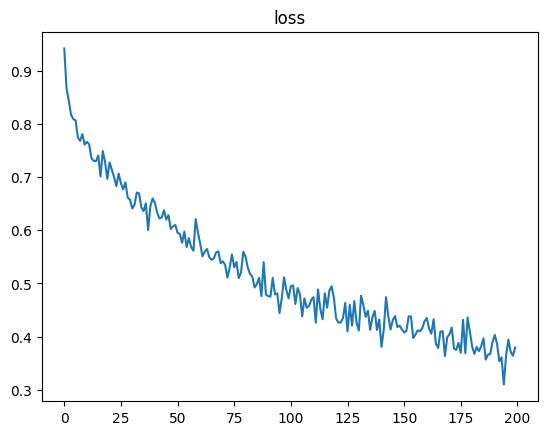

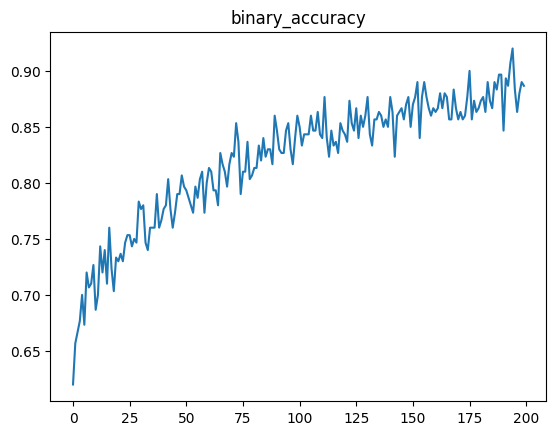

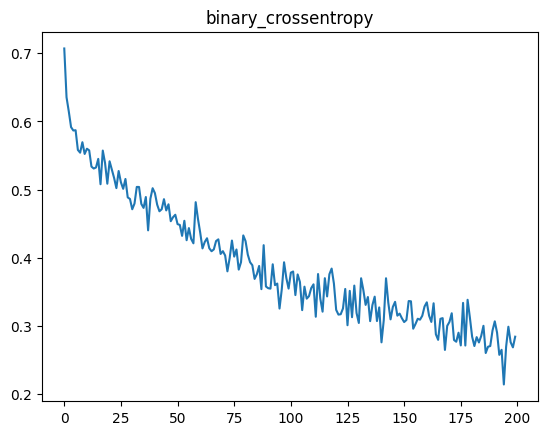

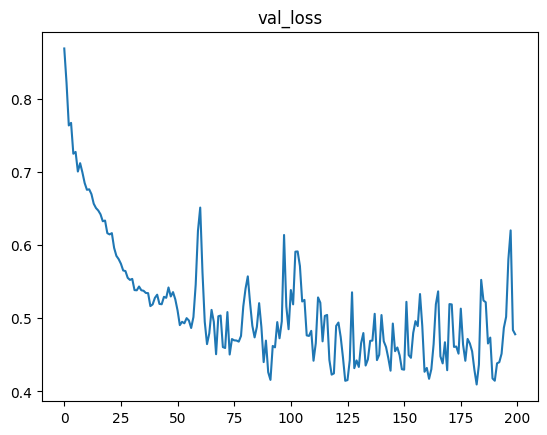

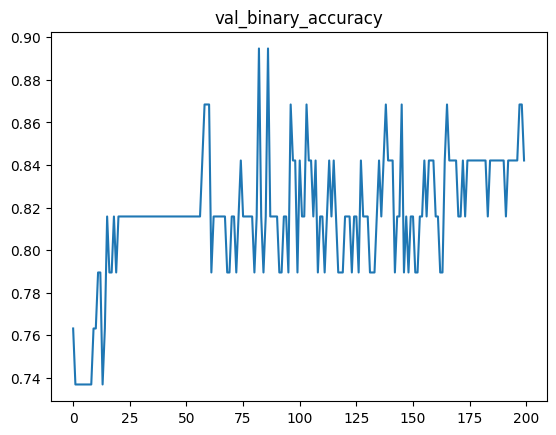

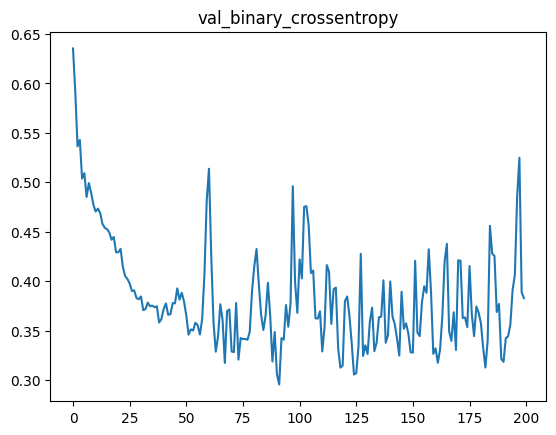

In [20]:
for k, hist in history.history.items():
  plt.plot(hist)
  plt.title(k)
  plt.show()

Feel free to play with the hyperparameters and the model architecture to improve the results!